## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.7, 0.9]
redice_lr_patient = [5, 8, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 2s 49us/step - loss: 1.2243 - acc: 0.5757 - val_loss: 1.4809 - val_acc: 0.4792
Epoch 14/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.2011 - acc: 0.5857 - val_loss: 1.4774 - val_acc: 0.4849
Epoch 15/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.1746 - acc: 0.5947 - val_loss: 1.4692 - val_acc: 0.4833
Epoch 16/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.1508 - acc: 0.6042 - val_loss: 1.4599 - val_acc: 0.4877
Epoch 17/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.1267 - acc: 0.6145 - val_loss: 1.4496 - val_acc: 0.4916
Epoch 18/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.1032 - acc: 0.6213 - val_loss: 1.4554 - val_acc: 0.4946
Epoch 19/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.0828 - acc: 0.6298 - val_loss: 1.4549 - val_acc: 0.4922
Epoch 20/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 70us/step - loss: 2.3525 - acc: 0.2400 - val_loss: 2.2407 - val_acc: 0.2926
Epoch 2/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.8721 - acc: 0.3542 - val_loss: 1.9121 - val_acc: 0.3541
Epoch 3/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.7312 - acc: 0.3961 - val_loss: 1.7920 - val_acc: 0.3811
Epoch 4/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6550 - acc: 0.4202 - val_loss: 1.7187 - val_acc: 0.4076
Epoch 5/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5999 - acc: 0.4385 - val_loss: 1.6682 - val_acc: 0.4203
Epoch 6/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5561 - acc: 0.4543 - val_loss: 1.6337 - val_acc: 0.4290
Epoch 7/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.5215 - acc: 0.4660 - val_loss: 1.6092 - val_acc

50000/50000 [==============================] - 2s 49us/step - loss: 1.1740 - acc: 0.5965 - val_loss: 1.4934 - val_acc: 0.4693
Epoch 25/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.1582 - acc: 0.6014 - val_loss: 1.4943 - val_acc: 0.4706
Numbers of exp: 5, reduce_factor: 0.70, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.3897 - acc: 0.5184 - val_loss: 1.5509 - val_acc: 0.4554
Epoch 13/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.3693 - acc: 0.5245 - val_loss: 1.5409 - val_acc: 0.4581
Epoch 14/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.3501 - acc: 0.5318 - val_loss: 1.5315 - val_acc: 0.4639
Epoch 15/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.3307 - acc: 0.5384 - val_loss: 1.5241 - val_acc: 0.4654
Epoch 16/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.3122 - acc: 0.5470 - val_loss: 1.5173 - val_acc: 0.4717
Epoch 17/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2968 - acc: 0.5521 - val_loss: 1.5134 - val_acc: 0.4684
Epoch 18/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2803 - acc: 0.5585 - val_loss: 1.5084 - val_acc: 0.4690
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 86us/step - loss: 2.3326 - acc: 0.2409 - val_loss: 2.2372 - val_acc: 0.2933
Epoch 2/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.8697 - acc: 0.3544 - val_loss: 1.9150 - val_acc: 0.3473
Epoch 3/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.7314 - acc: 0.3973 - val_loss: 1.8127 - val_acc: 0.3767
Epoch 4/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.6555 - acc: 0.4210 - val_loss: 1.7241 - val_acc: 0.3971
Epoch 5/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5998 - acc: 0.4420 - val_loss: 1.6855 - val_acc: 0.4127
Epoch 6/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.5587 - acc: 0.4548 - val_loss: 1.6541 - val_acc: 0.4215
Epoch 7/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.5220 - acc: 0.4679 - val_loss: 1.6234 - val_acc

50000/50000 [==============================] - 3s 60us/step - loss: 0.4721 - acc: 0.8590 - val_loss: 1.5072 - val_acc: 0.5229
Epoch 23/25
50000/50000 [==============================] - 3s 59us/step - loss: 0.4475 - acc: 0.8725 - val_loss: 1.4973 - val_acc: 0.5284
Epoch 24/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.4342 - acc: 0.8773 - val_loss: 1.5342 - val_acc: 0.5210
Epoch 25/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.4222 - acc: 0.8827 - val_loss: 1.5557 - val_acc: 0.5213
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch

50000/50000 [==============================] - 3s 60us/step - loss: 1.2768 - acc: 0.5589 - val_loss: 1.4879 - val_acc: 0.4763
Epoch 9/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.2463 - acc: 0.5704 - val_loss: 1.5025 - val_acc: 0.4706
Epoch 10/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.2207 - acc: 0.5823 - val_loss: 1.4775 - val_acc: 0.4812
Epoch 11/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.1950 - acc: 0.5916 - val_loss: 1.4780 - val_acc: 0.4825
Epoch 12/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.1706 - acc: 0.6001 - val_loss: 1.4541 - val_acc: 0.4889
Epoch 13/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.1498 - acc: 0.6098 - val_loss: 1.4679 - val_acc: 0.4897
Epoch 14/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.1279 - acc: 0.6161 - val_loss: 1.4533 - val_acc: 0.4916
Epoch 15/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 183us/step - loss: 2.0392 - acc: 0.3139 - val_loss: 1.9862 - val_acc: 0.3454
Epoch 2/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.6789 - acc: 0.4168 - val_loss: 1.7280 - val_acc: 0.4101
Epoch 3/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.5816 - acc: 0.4489 - val_loss: 1.6571 - val_acc: 0.4262
Epoch 4/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.5209 - acc: 0.4722 - val_loss: 1.6189 - val_acc: 0.4372
Epoch 5/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.4757 - acc: 0.4881 - val_loss: 1.5941 - val_acc: 0.4467
Epoch 6/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.4387 - acc: 0.5009 - val_loss: 1.5819 - val_acc: 0.4546
Epoch 7/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.4073 - acc: 0.5141 - val_loss: 1.5642 - val_ac

Epoch 24/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.1378 - acc: 0.6178 - val_loss: 1.4809 - val_acc: 0.4838
Epoch 25/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.1273 - acc: 0.6211 - val_loss: 1.4770 - val_acc: 0.4903
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch

50000/50000 [==============================] - 5s 98us/step - loss: 1.3270 - acc: 0.5443 - val_loss: 1.5242 - val_acc: 0.4683
Epoch 12/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.3085 - acc: 0.5499 - val_loss: 1.5269 - val_acc: 0.4673
Epoch 13/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.2907 - acc: 0.5577 - val_loss: 1.5183 - val_acc: 0.4727
Epoch 14/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.2743 - acc: 0.5649 - val_loss: 1.5155 - val_acc: 0.4694
Epoch 15/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.2586 - acc: 0.5697 - val_loss: 1.5067 - val_acc: 0.4775
Epoch 16/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.2438 - acc: 0.5763 - val_loss: 1.5051 - val_acc: 0.4726
Epoch 17/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.2291 - acc: 0.5813 - val_loss: 1.5024 - val_acc: 0.4757
Epoch 18/25
50000/50000 [=================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.8044 - acc: 0.3745 - val_loss: 2.1889 - val_acc: 0.3173
Epoch 2/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.5379 - acc: 0.4565 - val_loss: 2.1240 - val_acc: 0.3150
Epoch 3/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.4318 - acc: 0.4923 - val_loss: 2.0593 - val_acc: 0.3112
Epoch 4/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.3602 - acc: 0.5199 - val_loss: 2.0145 - val_acc: 0.3258
Epoch 5/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.2984 - acc: 0.5413 - val_loss: 2.1947 - val_acc: 0.3161
Epoch 6/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.2424 - acc: 0.5612 - val_loss: 1.9900 - val_acc: 0.3441
Epoch 7/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.1932 - acc: 0.5781 - val_loss: 2.5294 - 

Epoch 23/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.5871 - acc: 0.8113 - val_loss: 1.5883 - val_acc: 0.5009
Epoch 24/25
50000/50000 [==============================] - 5s 109us/step - loss: 0.5607 - acc: 0.8204 - val_loss: 1.6047 - val_acc: 0.5009
Epoch 25/25
50000/50000 [==============================] - 5s 102us/step - loss: 0.5376 - acc: 0.8316 - val_loss: 1.5962 - val_acc: 0.4957
Numbers of exp: 20, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_61 (Batc (None, 512)               2048      
______________________________________________________________

50000/50000 [==============================] - 3s 54us/step - loss: 1.2610 - acc: 0.5645 - val_loss: 1.5304 - val_acc: 0.4683
Epoch 10/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2285 - acc: 0.5779 - val_loss: 1.5744 - val_acc: 0.4555
Epoch 11/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1945 - acc: 0.5894 - val_loss: 1.5161 - val_acc: 0.4738
Epoch 12/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.1652 - acc: 0.5996 - val_loss: 1.5448 - val_acc: 0.4655
Epoch 13/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.1374 - acc: 0.6103 - val_loss: 1.5028 - val_acc: 0.4750
Epoch 14/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.1078 - acc: 0.6234 - val_loss: 1.4827 - val_acc: 0.4917
Epoch 15/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.0813 - acc: 0.6335 - val_loss: 1.5219 - val_acc: 0.4657
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 102us/step - loss: 2.3524 - acc: 0.2249 - val_loss: 2.1942 - val_acc: 0.2737
Epoch 2/25
50000/50000 [==============================] - 2s 49us/step - loss: 2.0160 - acc: 0.3100 - val_loss: 2.0247 - val_acc: 0.3174
Epoch 3/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.8740 - acc: 0.3522 - val_loss: 1.9183 - val_acc: 0.3410
Epoch 4/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.7840 - acc: 0.3802 - val_loss: 1.8411 - val_acc: 0.3679
Epoch 5/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.7163 - acc: 0.4008 - val_loss: 1.8008 - val_acc: 0.3789
Epoch 6/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.6648 - acc: 0.4195 - val_loss: 1.7559 - val_acc: 0.3913
Epoch 7/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.6234 - acc: 0.4325 - val_loss: 1.7222 - val_ac

50000/50000 [==============================] - 2s 47us/step - loss: 1.2935 - acc: 0.5571 - val_loss: 1.5410 - val_acc: 0.4656
Epoch 25/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.2814 - acc: 0.5610 - val_loss: 1.5298 - val_acc: 0.4702
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4957 - acc: 0.4814 - val_loss: 1.6320 - val_acc: 0.4355
Epoch 13/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.4731 - acc: 0.4901 - val_loss: 1.6249 - val_acc: 0.4361
Epoch 14/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.4517 - acc: 0.4964 - val_loss: 1.6078 - val_acc: 0.4429
Epoch 15/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.4311 - acc: 0.5041 - val_loss: 1.5984 - val_acc: 0.4461
Epoch 16/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.4132 - acc: 0.5120 - val_loss: 1.5973 - val_acc: 0.4476
Epoch 17/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.3964 - acc: 0.5170 - val_loss: 1.5823 - val_acc: 0.4528
Epoch 18/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.3785 - acc: 0.5240 - val_loss: 1.5786 - val_acc: 0.4497
Epoch 19/25
50000/50000 [=========

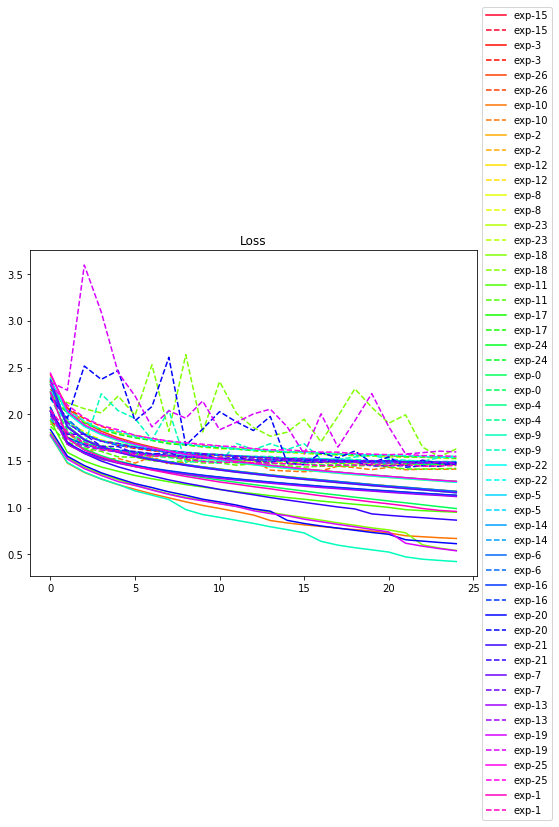

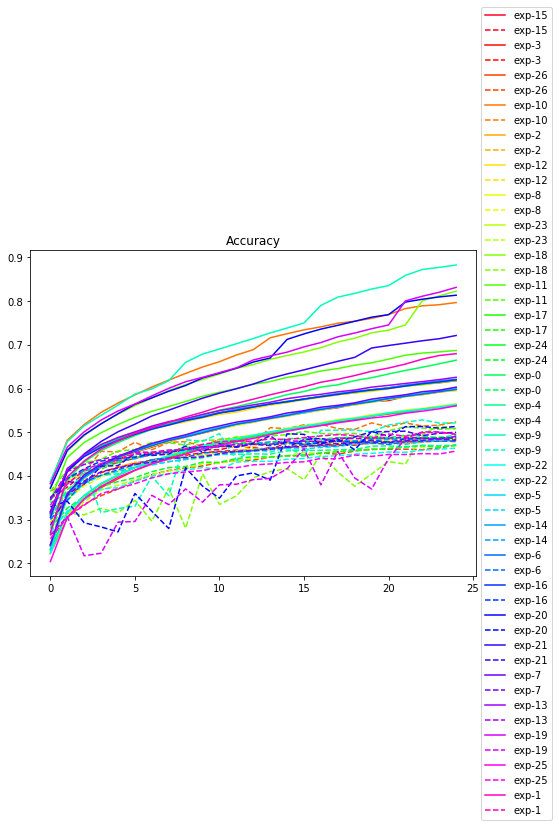

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()